<a href="https://colab.research.google.com/github/danielchang2002/evo_inverton_jacobian/blob/main/evo_inverton_jacobian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install evo

In [1]:
%%bash
pip -q install evo-model triton

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 73.6 MB/s eta 0:00:00


In [2]:
import os
DEVICE = 'cuda:0'
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'
from tqdm.notebook import tqdm
import numpy as np

In [3]:
from evo import Evo
import torch
import numpy as np

In [4]:
# load evo model from huggingface
evo_model = Evo('evo-1-8k-base')
model, tokenizer = evo_model.model, evo_model.tokenizer
DEVICE = 'cuda:0'
model.to(DEVICE)
model.eval()
print("loaded")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.89k [00:00<?, ?B/s]

configuration_hyena.py:   0%|          | 0.00/3.13k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/togethercomputer/evo-1-131k-base:
- configuration_hyena.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_hyena.py:   0%|          | 0.00/5.55k [00:00<?, ?B/s]

model.py:   0%|          | 0.00/19.5k [00:00<?, ?B/s]

tokenizer.py:   0%|          | 0.00/4.40k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/togethercomputer/evo-1-131k-base:
- tokenizer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


layers.py:   0%|          | 0.00/5.39k [00:00<?, ?B/s]

utils.py:   0%|          | 0.00/2.87k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/togethercomputer/evo-1-131k-base:
- utils.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/togethercomputer/evo-1-131k-base:
- layers.py
- utils.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


cache.py:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/togethercomputer/evo-1-131k-base:
- cache.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


engine.py:   0%|          | 0.00/13.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/togethercomputer/evo-1-131k-base:
- engine.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


positional_embeddings.py:   0%|          | 0.00/4.94k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/togethercomputer/evo-1-131k-base:
- positional_embeddings.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/togethercomputer/evo-1-131k-base:
- model.py
- tokenizer.py
- layers.py
- cache.py
- engine.py
- positional_embeddings.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/togethercomputer/evo-1-131k-base:
- modeling_hyena.py
- model.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/34.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

loaded


# Categorical jacobian functions

From https://github.com/sokrypton/ColabBio/blob/main/categorical_jacobian/evo_trna_example.ipynb

In [5]:
def reverse_complement(dna_sequence):
  complement_dict = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
  # Reverse the DNA sequence
  reversed_sequence = dna_sequence[::-1]
  # Replace each nucleotide with its complement
  reverse_complement_sequence = ''.join([complement_dict[nucleotide] for nucleotide in reversed_sequence])
  return reverse_complement_sequence


In [6]:
def get_categorical_jacobian(input_ids, input_ids_rev=None):
  nuc_tokens = (65,67,71,84) # (A,C,G,T)
  with torch.no_grad():
    f = lambda x:model(x)[0][...,:-1,nuc_tokens].cpu().detach().float().numpy()

    x = torch.clone(input_ids)
    ln = x.shape[1] - 1

    fx = f(x.to(DEVICE))[0]
    x = torch.tile(x,[4,1]).to(DEVICE)

    if input_ids_rev is not None:
      x_rev = torch.clone(input_ids_rev)
      fx_rev = f(x_rev.to(DEVICE))[0]
      fx += fx_rev[::-1,::-1]
      x_rev = torch.tile(x_rev,[4,1]).to(DEVICE)
    else:
      x_rev = None

    fx_h = np.zeros((ln,4,ln,4),dtype=np.float32)
    with tqdm(total=ln, bar_format=TQDM_BAR_FORMAT) as pbar:
      for n in range(ln): # for each position
        x_h = torch.clone(x)
        x_h[:,n+1] = torch.tensor(nuc_tokens)
        fx_h[n] = f(x_h)
        if x_rev is not None:
          x_rev_h = torch.clone(x_rev)
          x_rev_h[:,-(1+n)] = torch.tensor(nuc_tokens)
          fx_rev_h = f(x_rev_h)
          fx_h[n] += fx_rev_h[::-1,::-1,::-1]
        pbar.update(1)
    jac = fx_h-fx
  return jac

In [7]:
import matplotlib.pyplot as plt

def get_dependency_map(SEQ):

  input_ids = torch.tensor(
      [tokenizer.eod_id] + tokenizer.tokenize(SEQ),
      dtype=torch.int,
  ).to(DEVICE).unsqueeze(0)

  input_ids_rev = torch.tensor(
      [tokenizer.eod_id] + tokenizer.tokenize(reverse_complement(SEQ)),
      dtype=torch.int,
  ).to(DEVICE).unsqueeze(0)

  jac_control_both = get_categorical_jacobian(input_ids, input_ids_rev)

  J = jac_control_both.copy()
  for k in range(4):
    J -= J.mean(k,keepdims=True)

  con = np.sqrt(np.square(J).sum((1,3)))

  # average product correction
  apc = con - (con.sum(keepdims=0) * con.sum(keepdims=1)) / con.sum()

  return apc


# tRNA example

In [8]:
trna = "GGUGGGGUUC CCGAGCGGCC AAAGGGAGCA GACUGUAAAU CUGCCGUCAU CGACUUCGAA GGUUCGAAUC CUUCCCCCAC CACCA"
trna = trna.replace(" ","").replace("U","T")
trna

'GGTGGGGTTCCCGAGCGGCCAAAGGGAGCAGACTGTAAATCTGCCGTCATCGACTTCGAAGGTTCGAATCCTTCCCCCACCACCA'

In [9]:
apc = get_dependency_map(trna)

  0%|          | 0/85 [elapsed: 00:00 remaining: ?]

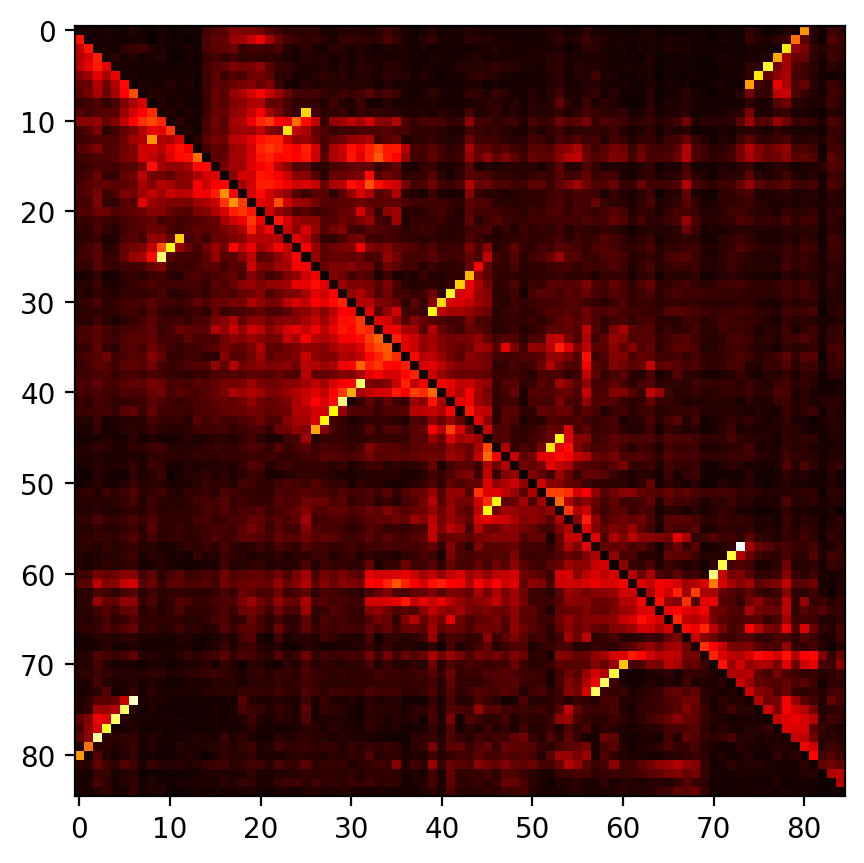

In [10]:
plt.figure(figsize=(5,5),dpi=200)
plt.imshow(apc, cmap="hot")
plt.show()

# Inverton example

In [11]:
%%capture
%%bash
# download Bacteroides thetaiotaomicron VPI-5482 assembly
wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/011/065/GCF_000011065.1_ASM1106v1/GCF_000011065.1_ASM1106v1_genomic.fna.gz

In [12]:
%%bash
pip install -q fasta_reader

In [13]:
from Bio.Seq import Seq
from fasta_reader import read_fasta

btheta_genome = [item.sequence for item in read_fasta("/content/GCF_000011065.1_ASM1106v1_genomic.fna.gz")][0]
len(btheta_genome)

6260361

In [14]:
# inverton information from Jiang et al https://doi.org/10.1126%2Fscience.aau5238

invertase = (339757, 340723)
IR1 = 340745
IR2 = 341011
IR_len = 22
buffer = 50

# extract inverton substring info
inverton_substring = btheta_genome[invertase[0] : IR2 + IR_len + buffer]

invertase_pos = 0
invertase_len = invertase[1] - invertase[0]

IR1_pos = IR1 - invertase[0]
IR2_pos = IR2 - invertase[0]

len(inverton_substring)

1326

In [15]:
# sanity check inverted repeats

print(inverton_substring[IR1_pos : IR1_pos + IR_len])
print(inverton_substring[IR2_pos : IR2_pos + IR_len])

Seq(inverton_substring[IR1_pos : IR1_pos + IR_len]) == \
  Seq(inverton_substring[IR2_pos : IR2_pos + IR_len]).reverse_complement()

GTTACTTCTTAGGTAACGGAAA
TTTCCGTTACCTAAGAAGTAAC


True

In [16]:
# sanity check invertase sequence

# Bacteroides thetaiotaomicron tyrosine-type DNA invertase cluster 3b

# https://www.uniprot.org/uniprotkb/A0A7J5JMR9/entry#family_and_domains
core_binding_domain = (5 * 3, 88 * 3)
core_binding_domain_len = core_binding_domain[1] - core_binding_domain[0]

# cross reference w/ https://www.uniprot.org/uniprotkb/A0A7J5JMR9/entry#sequences
seq = Seq(inverton_substring[invertase_pos : invertase_pos + invertase_len])
seq.translate()

Seq('MMKKNGFSRCAEMYIGRLRKEGRYSTAHVYENALLSFRGFCGTPTVSFGQVTRE...KY*')

In [17]:
# compute jacobian!

apc = get_dependency_map(inverton_substring)

  0%|          | 0/1326 [elapsed: 00:00 remaining: ?]

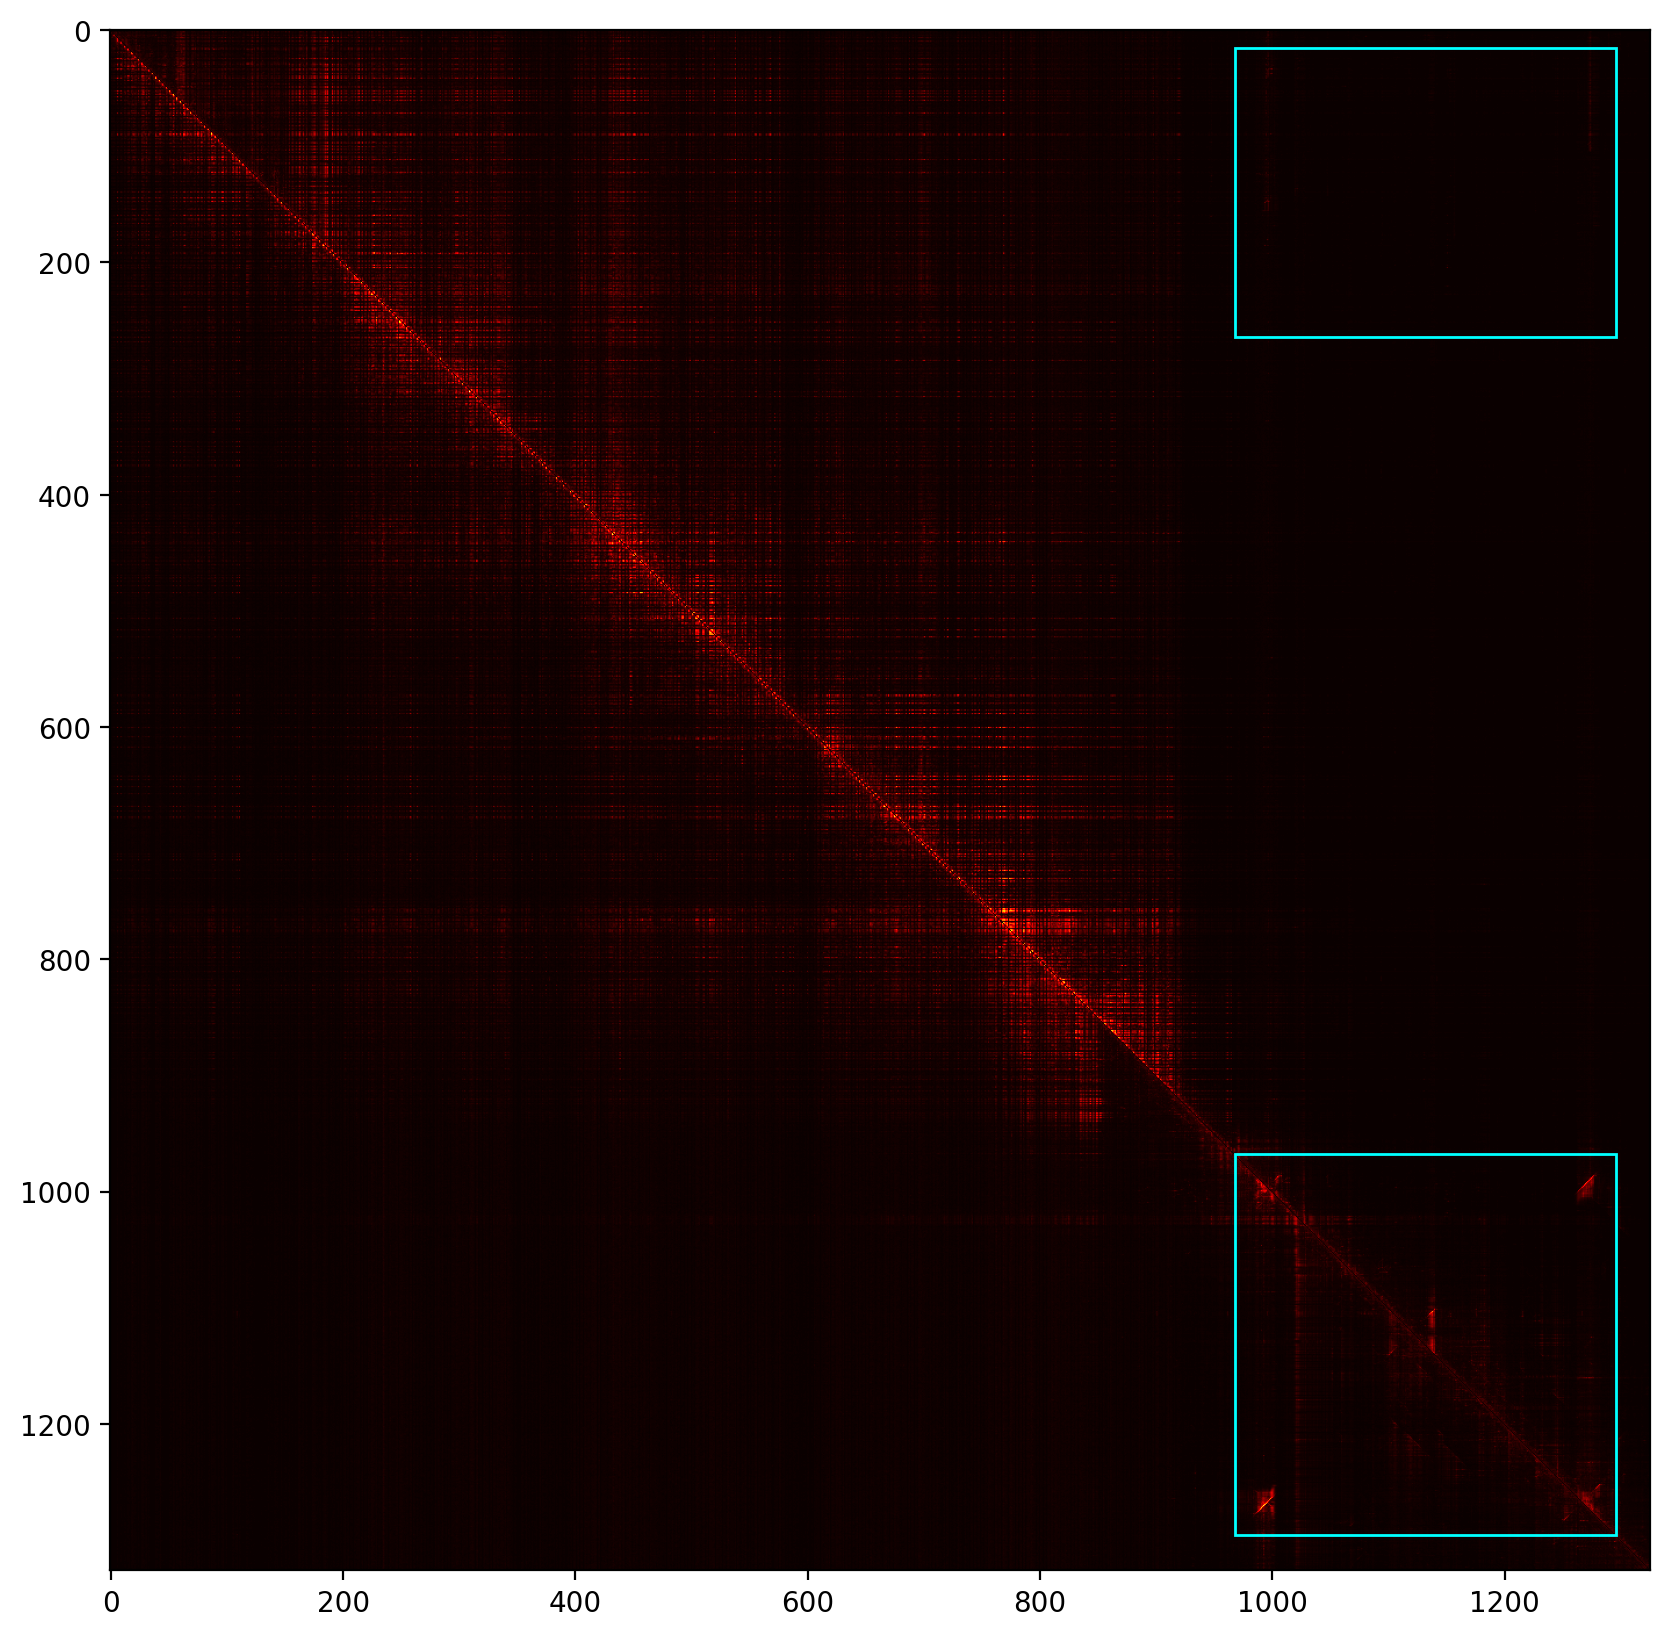

In [18]:
import matplotlib.pyplot as plt
from matplotlib import patches

# plot entire dependency map

buffer2 = 20

plt.figure(figsize=(10, 10), dpi=200)
plt.imshow(apc, cmap="hot")

rect = patches.Rectangle((IR1_pos - buffer2, core_binding_domain[0]), IR2_pos + buffer2 + IR_len - (IR1_pos - buffer2), core_binding_domain_len, linewidth=1, edgecolor='cyan', facecolor='none')
plt.gca().add_patch(rect)

rect = patches.Rectangle((IR1_pos - buffer2, IR1_pos - buffer2), IR2_pos + buffer2 + IR_len - (IR1_pos - buffer2), IR2_pos + buffer2 + IR_len - (IR1_pos - buffer2), linewidth=1, edgecolor='cyan', facecolor='none')
plt.gca().add_patch(rect)

plt.show()

In [19]:
apc.shape

(1326, 1326)

In [21]:
# save apc
np.save("apc_IBP327.npy", apc)

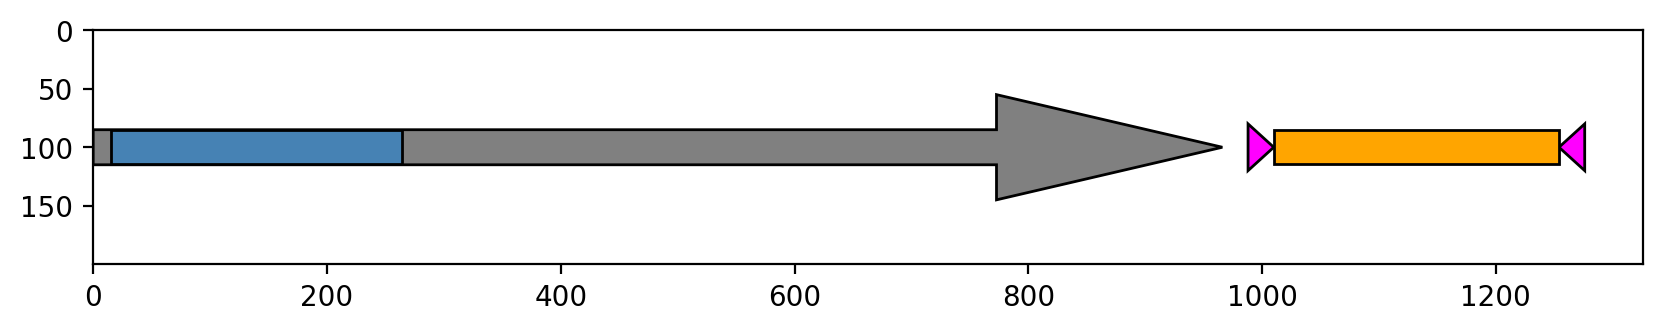

In [22]:
from matplotlib.patches import FancyArrowPatch, Polygon

# annotate the sequence

plt.figure(figsize=(10, 10), dpi=200)

plt.imshow(np.zeros((200, apc.shape[0])), cmap="Greys")

# invertase
arrow = patches.Arrow(0, 100, invertase_len, 0, width=150, edgecolor='k', facecolor='gray')
plt.gca().add_patch(arrow)

# core binding domain
rect = patches.Rectangle((core_binding_domain[0], 85), core_binding_domain_len, 29, linewidth=1, edgecolor='black', facecolor='steelblue')
plt.gca().add_patch(rect)

# inverted repeats
left_x = IR1_pos
right_x = IR1_pos + IR_len
top_y = 80
bottom_y = 120
triangle_vertices = [(left_x, top_y), (left_x, bottom_y), (right_x, (top_y + bottom_y) / 2)]
triangle = Polygon(triangle_vertices, closed=True, edgecolor='k', facecolor='magenta', linewidth=1)
plt.gca().add_patch(triangle)

left_x = IR2_pos
right_x = IR2_pos + IR_len
triangle_vertices = [(right_x, top_y), (right_x, bottom_y), (left_x, (top_y + bottom_y) / 2)]
triangle = Polygon(triangle_vertices, closed=True, edgecolor='k', facecolor='magenta', linewidth=1)
plt.gca().add_patch(triangle)

# invertable region
rect = patches.Rectangle((IR1_pos + IR_len, 85), IR2_pos - (IR1_pos + IR_len), 29, linewidth=1, edgecolor='black', facecolor='orange')
plt.gca().add_patch(rect)

plt.show()

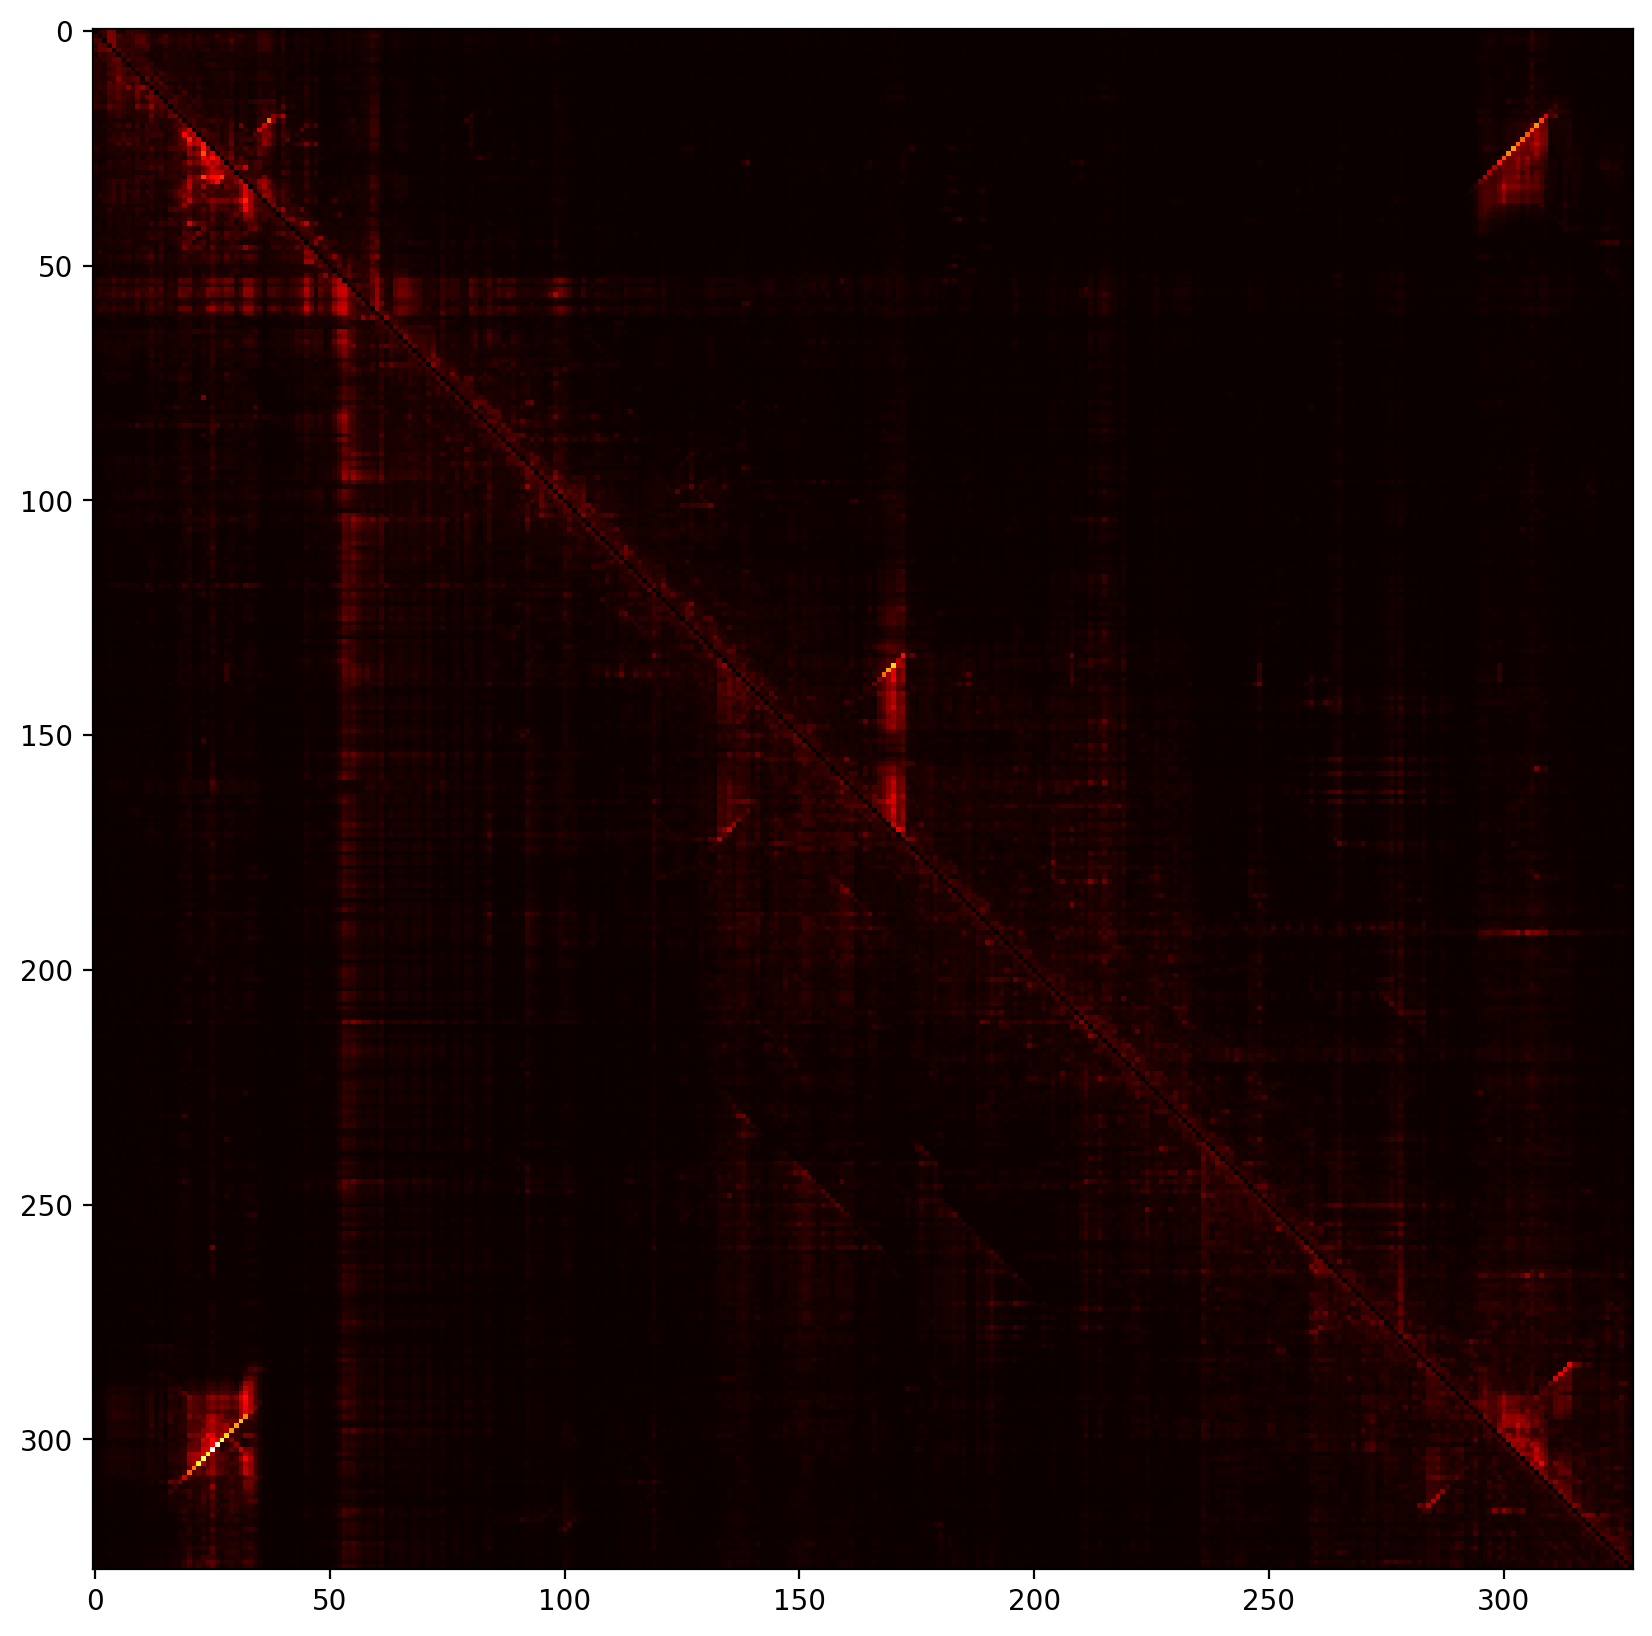

In [23]:
# plot inverton vs. inverton dependency subregion

plt.figure(figsize=(10, 10),dpi=200)
inverton_region_apc = apc[IR1_pos - buffer2: IR2_pos + IR_len + buffer2, IR1_pos - buffer2: IR2_pos + IR_len + buffer2]
plt.imshow(inverton_region_apc, cmap="hot")

plt.show()

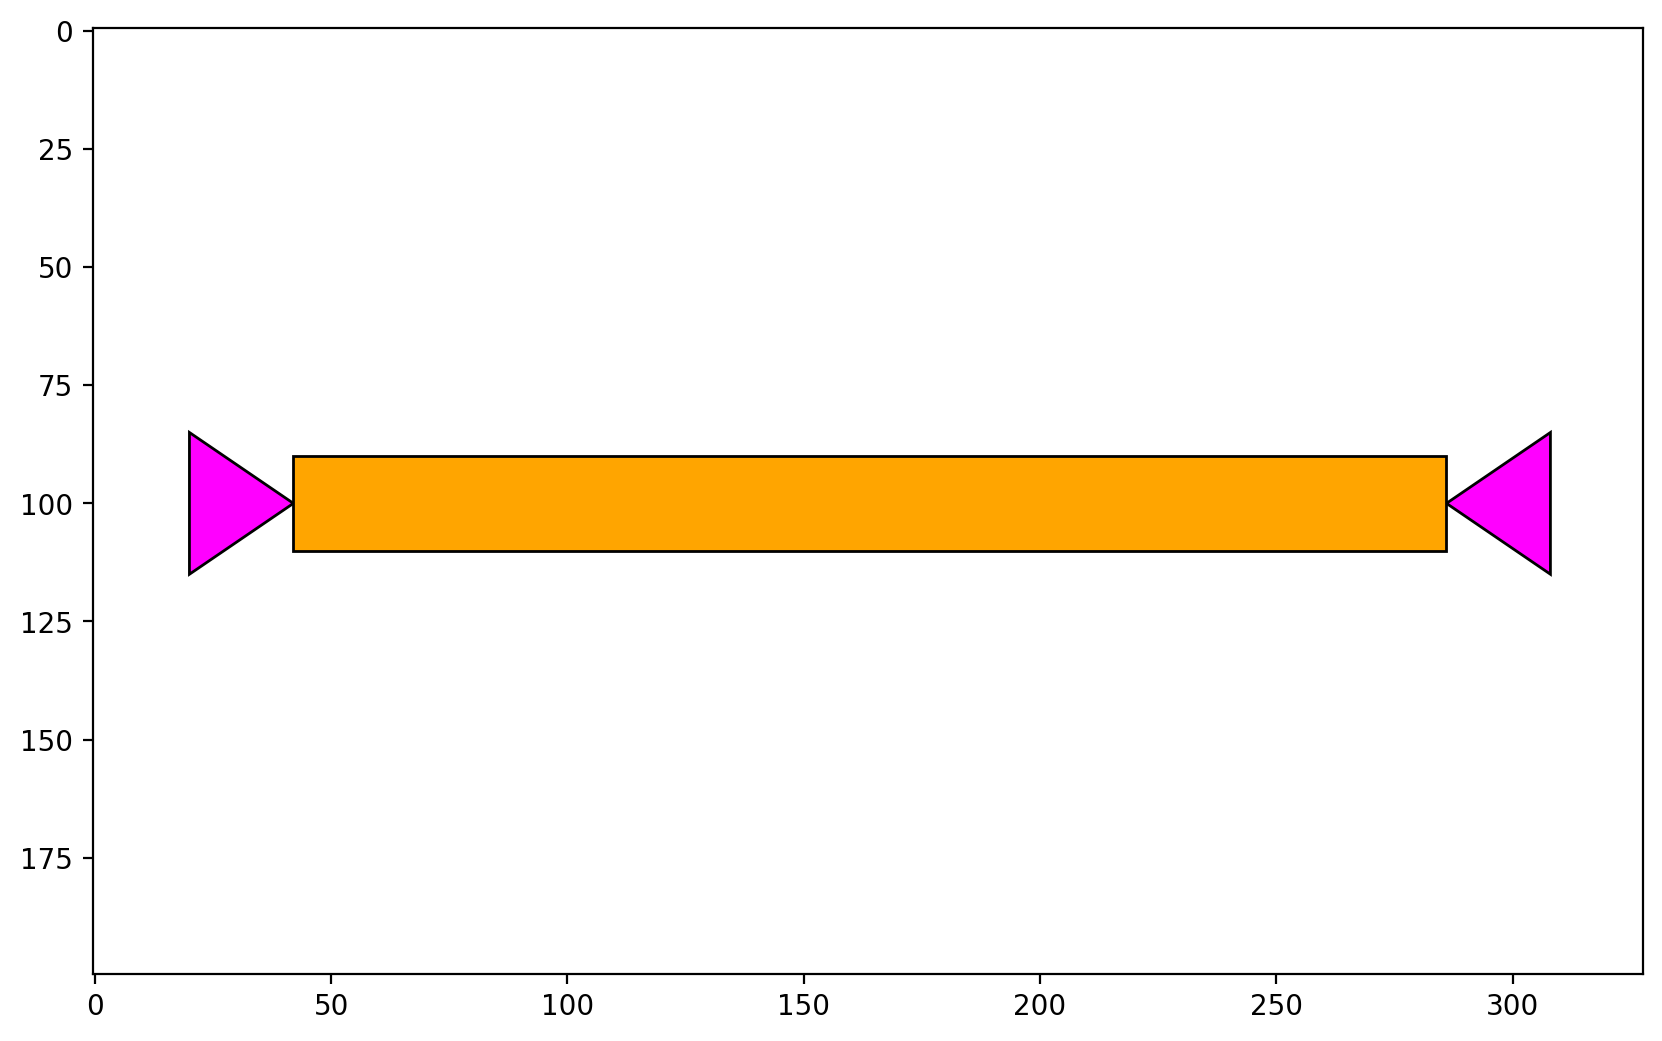

In [25]:
# annotate inverton subregion

plt.figure(figsize=(10, 10), dpi=200)

plt.imshow(np.zeros((200, inverton_region_apc.shape[0])), cmap="Greys")

offset = IR1_pos - buffer2

# inverted repeats
left_x = IR1_pos - offset
right_x = IR1_pos + IR_len - offset
top_y = 85
bottom_y = 115
triangle_vertices = [(left_x, top_y), (left_x, bottom_y), (right_x, (top_y + bottom_y) / 2)]
triangle = Polygon(triangle_vertices, closed=True, edgecolor='k', facecolor='magenta', linewidth=1)
plt.gca().add_patch(triangle)

left_x = IR2_pos - offset
right_x = IR2_pos + IR_len - offset
triangle_vertices = [(right_x, top_y), (right_x, bottom_y), (left_x, (top_y + bottom_y) / 2)]
triangle = Polygon(triangle_vertices, closed=True, edgecolor='k', facecolor='magenta', linewidth=1)
plt.gca().add_patch(triangle)

# invertable region
rect = patches.Rectangle((IR1_pos + IR_len - offset, 90), IR2_pos - (IR1_pos + IR_len), 20, linewidth=1, edgecolor='black', facecolor='orange')
plt.gca().add_patch(rect)

plt.show()

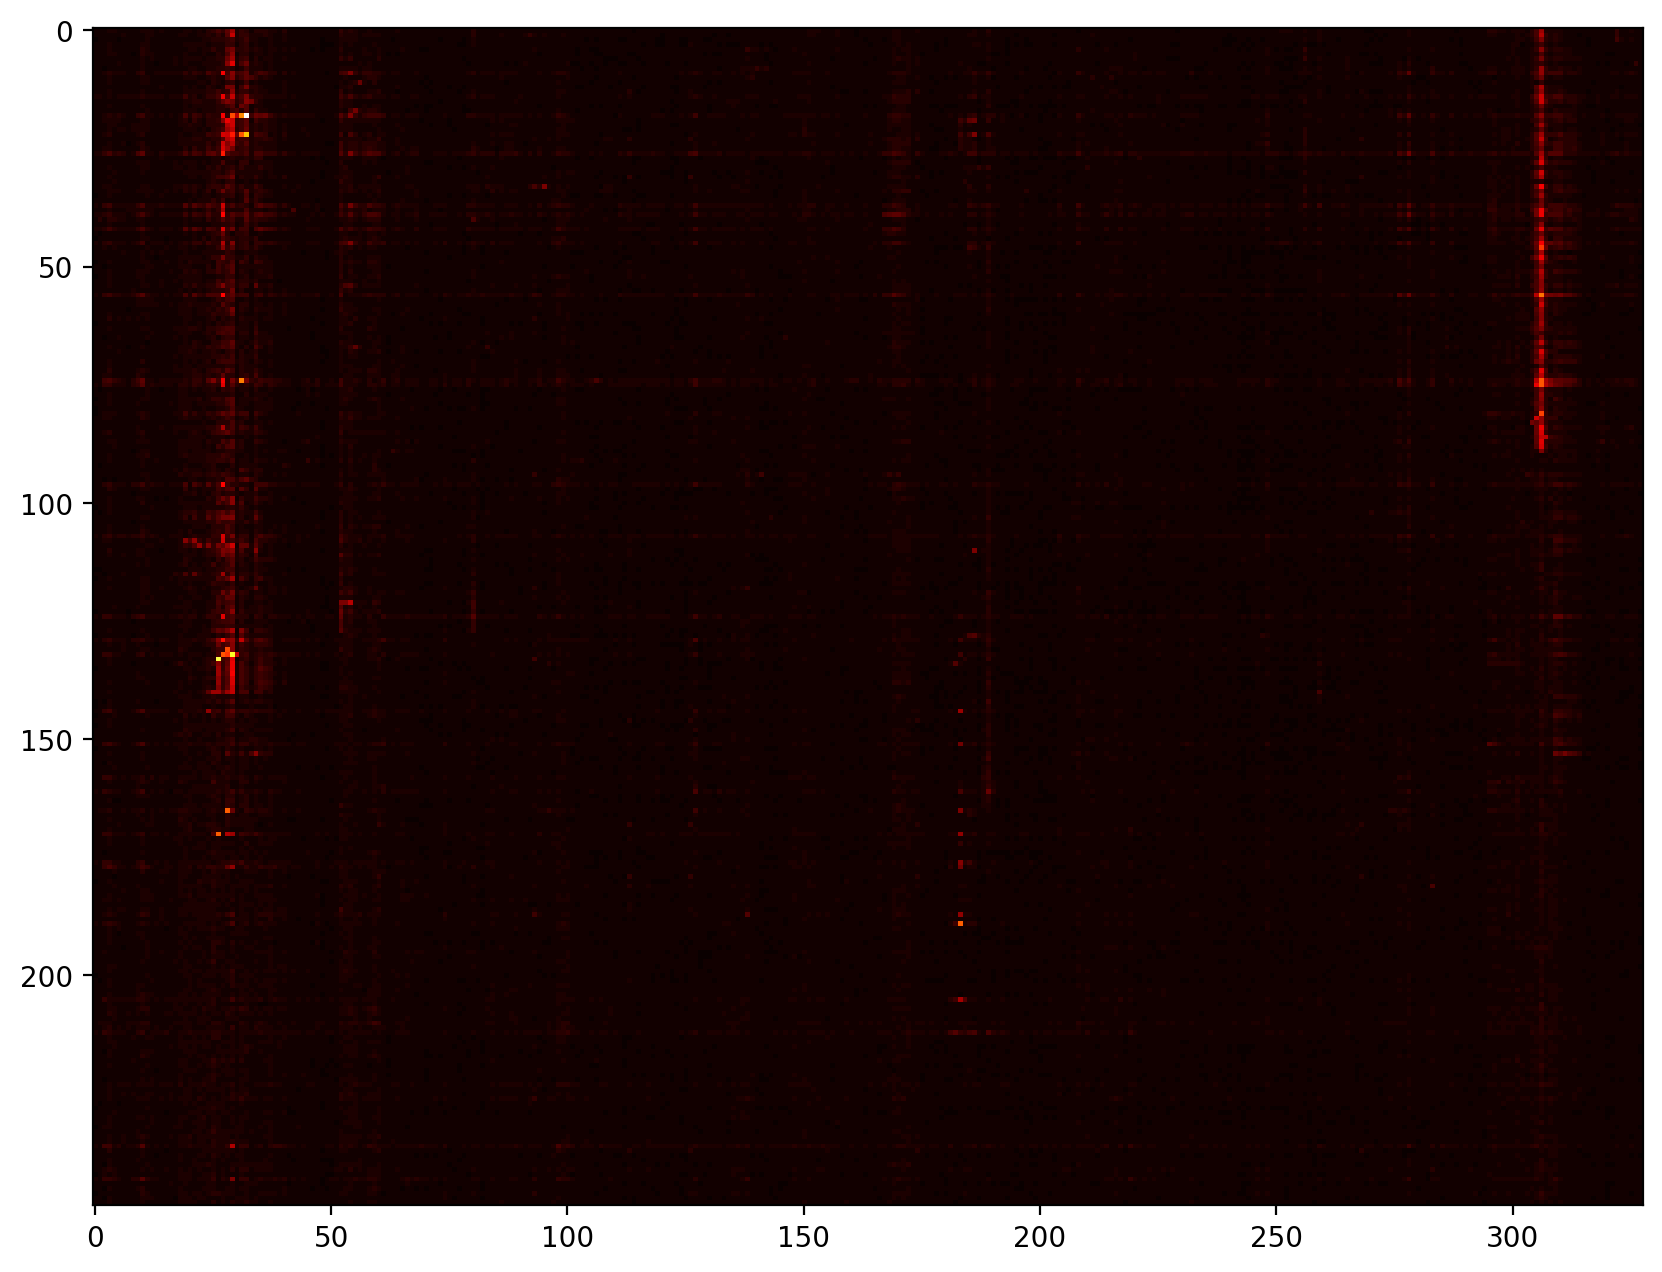

In [29]:
# plot inverton vs. invertase core binding domain dependency map

plt.figure(figsize=(10, 10),dpi=200)
plt.imshow(apc[core_binding_domain[0] : core_binding_domain[1], IR1_pos - buffer2 : IR2_pos + buffer2 + IR_len], cmap="hot")
plt.show()

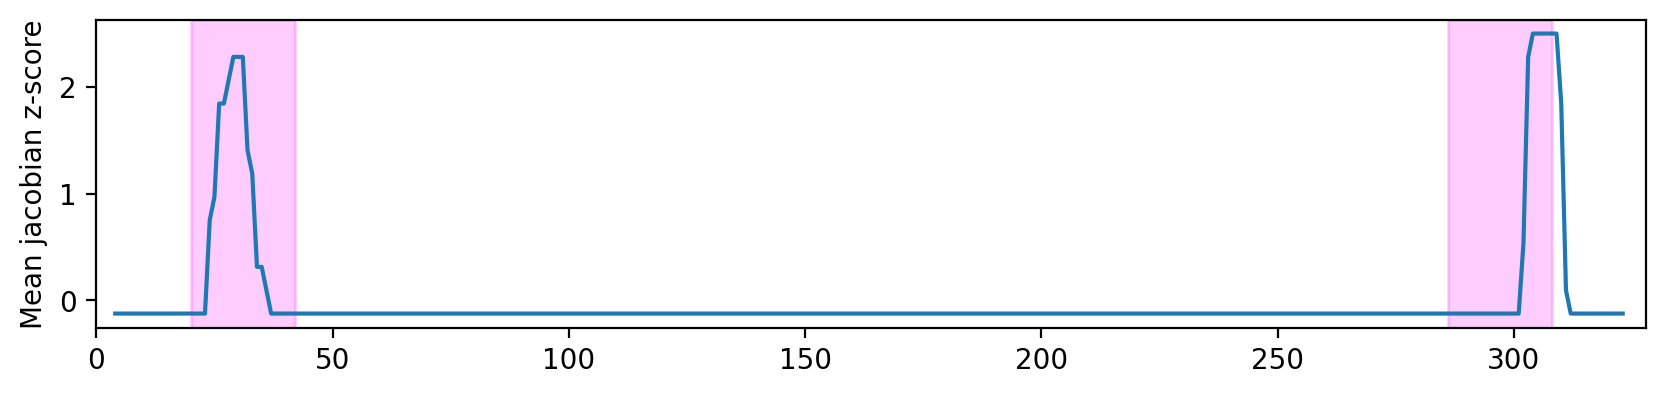

In [30]:
# plot moving average of mean inverton vs. core binding domain dependency, across inverton positions

from sklearn.preprocessing import StandardScaler

plt.figure(figsize=(10, 2),dpi=200)

scaler = StandardScaler()

apc_core_binding_IR = apc[core_binding_domain[0] : core_binding_domain[1], IR1_pos - buffer2 : IR2_pos + IR_len + buffer2]

mean_apc = np.mean(apc_core_binding_IR, axis=0)
mean_apc = scaler.fit_transform(mean_apc.reshape(-1, 1)).reshape(-1)

def moving_average(data, window_size):
    assert(window_size % 2 == 0)
    side = window_size // 2
    average = []
    for ind in range(side, len(data) - side):
        average.append(np.mean(data[ind - side : ind + side]))
    return average


# plt.bar(np.arange(len(mean_apc)), mean_apc)
# plt.plot(np.arange(len(mean_apc)), mean_apc)

window_size = 8
side = window_size // 2
smoothed_apc = moving_average(mean_apc, window_size)
plt.plot(range(side, len(mean_apc) - side), smoothed_apc)

plt.axvspan(buffer2, buffer2 + IR_len, color='magenta', alpha=0.2)
plt.axvspan(mean_apc.shape[0] - buffer2 - IR_len, mean_apc.shape[0] - buffer2, color='magenta', alpha=0.2)

plt.ylabel("Mean jacobian z-score")

plt.xlim(0, inverton_region_apc.shape[0])

plt.show()